# The Causal Story Behind Hotel Booking Cancellations

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 123 kB 5.4 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [ ]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [ ]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')


,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces
0,27,1,BB,PRT,Direct,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0
1,27,1,BB,PRT,Direct,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0
2,27,1,BB,GBR,Direct,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0
3,27,1,BB,GBR,Corporate,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0
4,27,1,BB,GBR,Online TA,TA/TO,0,0,0,0,No Deposit,0,Transient,98.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,27,3,BB,PRT,Online TA,TA/TO,0,0,0,0,No Deposit,0,Transient,73.80,0
96,27,3,BB,PRT,Online TA,TA/TO,0,0,0,0,No Deposit,0,Transient,117.00,0
97,27,3,HB,ESP,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0
98,27,3,BB,PRT,Online TA,TA/TO,0,0,0,0,No Deposit,0,Transient,99.30,1


In [ ]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  ...  guests  different_room_assigned
deposit_type is_canceled                    ...                                 
No Deposit   False        74947      74947  ...   74947                    74947
             True         29690      29690  ...   29690                    29690

[2 rows x 24 columns]

In [ ]:
dataset_copy = dataset.copy(deep=True)

In [ ]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [ ]:
# Expected Count when there are no booking changes
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [ ]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In [ ]:
!apt-get install -y graphviz-dev
!sudo pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubun

In [ ]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

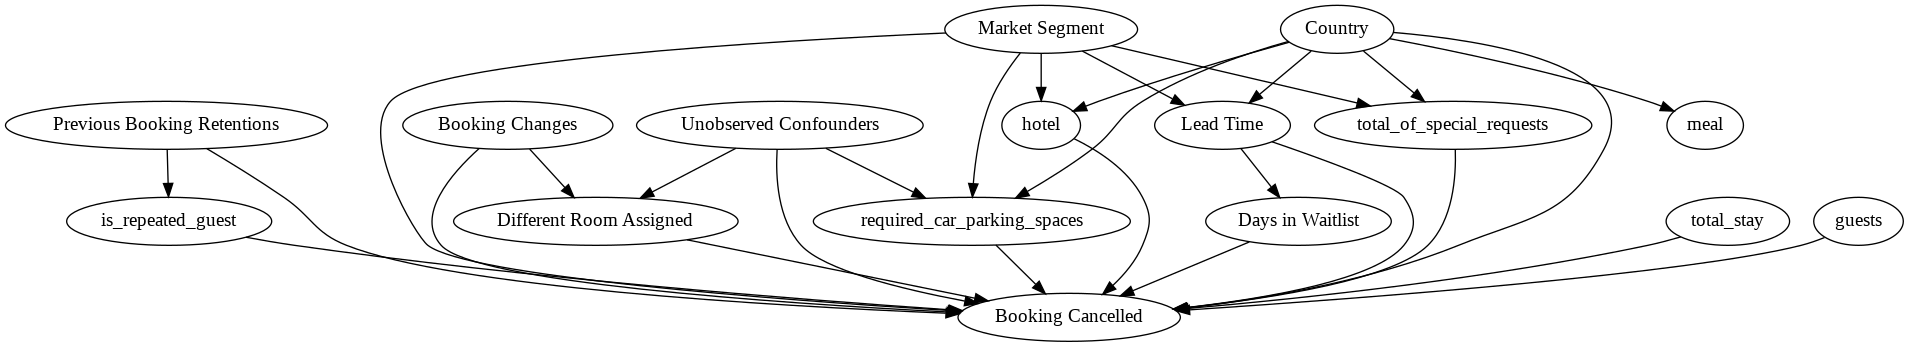

In [ ]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,days_in_waiting_list,total_of_special_requests,previous_bookings_not_canceled
                                                                              

                                                                              
,hotel,market_segment,country,total_stay,guests,lead_time,is_repeated_guest,me
                                                                              

                    
al,booking_changes))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|required_car_parking_spaces
d[different_room_assigned]                                                    

                                                                              
,days_in_waiting_list,total_of_special_requests,previous_bookings_not_canceled
                                                                              

                                                                              
,hotel,market_segment,country,total_stay,guests,lead_time,is_repeated_guest,me
                                                                              

                    
al,booking_changes))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

In [ ]:
# Refute method 1
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.25072968242685
New effect:-0.24938151594798982



# Lalonde dataset

In [ ]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

%R install.packages("Matching")
%R library(Matching)


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.9-10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 385267 bytes (376 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

'Matching','MASS','tools',...,'datasets','methods','base'


In [ ]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)

In [ ]:
model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        common_causes='nodegr+black+hisp+age+educ+married'.split('+'))
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting",
        method_params={"weighting_scheme":"ips_weight"})
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                          
────────(Expectation(re78|educ,hisp,black,age,married,nodegr))
d[treat]                                                      
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,educ,hisp,black,age,married,nodegr,U) = P(re78|treat,educ,hisp,black,age,married,nodegr)

## Realized estimand
b: re78~treat+educ+hisp+black+age+married+nodegr
Target units: ate

## Estimate
Mean value: 1614.04048687053

Causal Estimate is 1614.04048687053


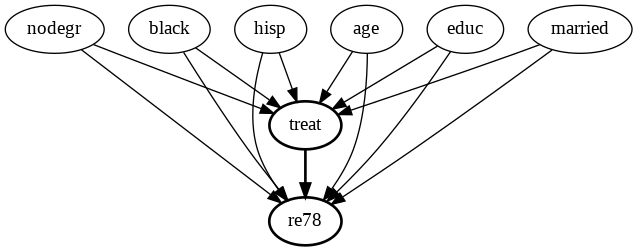

In [ ]:
model.view_model(layout="dot")
display(Image(filename="causal_model.png"))

/usr/local/lib/python3.7/dist-packages/dowhy/interpreters/confounder_distribution_interpreter.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = df[treated] * (propensity) ** (-1) + (1 - df[treated]) * (1 - propensity) ** (-1)


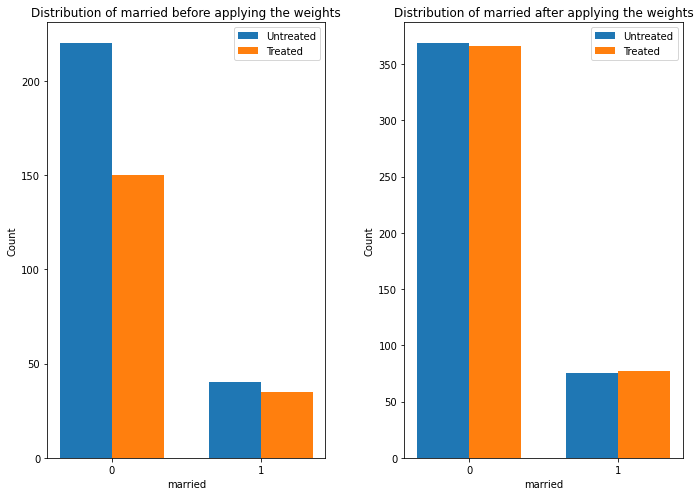

In [ ]:
estimate.interpret(method_name="confounder_distribution_interpreter",var_type='discrete',
                   var_name='married', fig_size = (10, 7), font_size = 12)

In [ ]:
df = model._data
ps = df['ps']
y = df['re78']
z = df['treat']

ey1 = z*y/ps / sum(z/ps)
ey0 = (1-z)*y/(1-ps) / sum((1-z)/(1-ps))
ate = ey1.sum()-ey0.sum()
print("Causal Estimate is " + str(ate))

# correct -> Causal Estimate is 1634.9868359746906

Causal Estimate is 1639.7923423479215


# Twins dataset

In [ ]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from dowhy import causal_estimators

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [ ]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

#The outcome data contains mortality of the lighter and heavier twin
y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv")

#The treatment data contains weight in grams of both the twins
t = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv")

In [ ]:
#_0 denotes features specific to the lighter twin and _1 denotes features specific to the heavier twin
lighter_columns = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'dlivord_min', 'dtotord_min', 'bord_0',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
heavier_columns = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [ ]:
#Since data has pair property,processing the data to get separate row for each twin so that each child can be treated as an instance
data = []

for i in range(len(t.values)):

    #select only if both <=2kg
    if t.iloc[i].values[1]>=2000 or t.iloc[i].values[2]>=2000:
        continue

    this_instance_lighter = list(x.iloc[i][lighter_columns].values)
    this_instance_heavier = list(x.iloc[i][heavier_columns].values)

    #adding weight
    this_instance_lighter.append(t.iloc[i].values[1])
    this_instance_heavier.append(t.iloc[i].values[2])

    #adding treatment, is_heavier
    this_instance_lighter.append(0)
    this_instance_heavier.append(1)

    #adding the outcome
    this_instance_lighter.append(y.iloc[i].values[1])
    this_instance_heavier.append(y.iloc[i].values[2])
    data.append(this_instance_lighter)
    data.append(this_instance_heavier)

In [ ]:
cols = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id', 'dlivord_min', 'dtotord_min', 'bord',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg','wt','treatment','outcome']
df = pd.DataFrame(columns=cols,data=data)
df.head()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,mpre5,adequacy,orfath,frace,birmon,gestat10,csex,anemia,cardiac,lung,diabetes,herpes,hydra,hemo,chyper,phyper,eclamp,incervix,pre4000,preterm,renal,rh,uterine,othermr,tobacco,alcohol,cigar6,drink5,crace,data_year,nprevistq,dfageq,feduc6,infant_id,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,1.0,3.0,35.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,1.0,3.0,34.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
2,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,4.0,3.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,NaN,NaN,47.0,NaN,NaN,NaN,5.0,5.0,5.0,737.0,0,0.0
3,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,4.0,3.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,NaN,NaN,46.0,NaN,NaN,NaN,5.0,5.0,5.0,850.0,1,1.0
4,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,NaN,0.0,3.0,52.0,1.0,1.0,1.0,5.0,5.0,5.0,1830.0,0,0.0


In [ ]:
df = df.astype({"treatment":'bool'}, copy=False) #explicitly assigning treatment column as boolean

df.fillna(value=df.mean(),inplace=True)    #filling the missing values
df.fillna(value=df.mode().loc[0],inplace=True)

data_1 = df[df["treatment"]==1]
data_0 = df[df["treatment"]==0]
print(np.mean(data_1["outcome"]))
print(np.mean(data_0["outcome"]))
print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))

0.16421895861148197
0.1894192256341789
ATE -0.025200267022696926


In [ ]:
#The causal model has "treatment = is_heavier", "outcome = mortality" and "gestat10 = gestational weeks before birth"
model=CausalModel(
        data = df,
        treatment='treatment',
        outcome='outcome',
        common_causes='gestat10'
        )

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(Expectation(outcome|gestat10))
d[treatment]                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,gestat10,U) = P(outcome|treatment,gestat10)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [ ]:
# Estimate Using Linear Regression
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)
print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))
print("Causal Estimate is " + str(estimate.value))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                     
────────────(Expectation(outcome|gestat10))
d[treatment]                               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,gestat10,U) = P(outcome|treatment,gestat10)

## Realized estimand
b: outcome~treatment+gestat10
Target units: ate

## Estimate
Mean value: -0.025200267022693457
p-value: [7.18902894e-08]

ATE -0.025200267022696926
Causal Estimate is -0.025200267022693457


In [ ]:
# Using Propensity Score Matching
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching"
)

print("Causal Estimate is " + str(estimate.value))

print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))

Causal Estimate is -0.012600133511348465
ATE -0.025200267022696926


In [ ]:
# refute 1: Adding a random cause
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:-0.012600133511348465
New effect:-0.025826101468624834



In [ ]:
# refute 2: Using a placebo treatment
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.012600133511348465
New effect:0.009696261682242992
p value:0.46188824654784666



In [ ]:
# refute 3: Using a data subset refuter
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9,
        num_simulations=20)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.012600133511348465
New effect:-0.07368689444161143
p value:0.32406122377758007

